In [7]:
#
# Experiment 2: Fine-Tuning a Pre-trained CNN (VGG16) on a Custom Dataset (CIFAR-10)
#

# ###################################################################
# 1. IMPORT LIBRARIES
# ###################################################################
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt



In [8]:
# ###################################################################
# 2. DATASET PREPROCESSING
# ###################################################################

print("Loading and preprocessing the CIFAR-10 dataset...")

# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# CIFAR-10 class names for later visualization
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(class_names)

# --- Data Normalization ---
# Convert pixel values from integers (0-255) to floating-point (0-1)
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# --- Label Encoding ---
# Convert class vectors to binary class matrices (one-hot encoding)
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# --- Image Resizing ---
# VGG16 was trained on 224x224 images, but it can handle different sizes.
# We will resize CIFAR-10's 32x32 images to a slightly larger size (e.g., 48x48)
# to retain more features without being computationally excessive.
# Using a Lambda layer or tf.image.resize directly in a data pipeline is efficient.
# For simplicity here, we'll resize them before training.


Loading and preprocessing the CIFAR-10 dataset...


In [9]:
target_size = (48, 48)
x_train_resized = tf.image.resize(x_train, target_size)
x_test_resized = tf.image.resize(x_test, target_size)

print(f"Original training data shape: {x_train.shape}")
print(f"Resized training data shape: {x_train_resized.shape}")
print(f"Training labels shape: {y_train.shape}")

# ###################################################################
# 3. BUILD MODEL (Transfer Learning)
# ###################################################################

print("\nBuilding the model using VGG16 as a base...")

# --- Load the Pre-trained Base Model (VGG16) ---
# We load VGG16 with weights pre-trained on ImageNet.
# `include_top=False` means we exclude the final fully-connected layers
# that were specific to ImageNet's 1000 classes.
# `input_shape` matches our resized images.
input_shape = (target_size[0], target_size[1], 3)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# --- Freeze the Convolutional Base ---
# We freeze the layers of the base model so that their pre-trained weights
# are not updated during the initial training phase. This preserves the
# learned features from ImageNet.
for layer in base_model.layers:
    layer.trainable = False

# --- Add a Custom Classifier Head ---
# We stack our own classification layers on top of the frozen base.
# This new "head" will be trained from scratch on the CIFAR-10 dataset.
x = base_model.output
x = Flatten()(x) # Flatten the output of the conv base
x = Dense(512, activation='relu')(x) # Add a dense layer
x = Dropout(0.5)(x) # Add dropout for regularization
predictions = Dense(num_classes, activation='softmax')(x) # Final output layer for our 10 classes

# --- Create the Final Model ---
# This is the final model we will train.
model = Model(inputs=base_model.input, outputs=predictions)



Original training data shape: (50000, 32, 32, 3)
Resized training data shape: (50000, 48, 48, 3)
Training labels shape: (50000, 10)

Building the model using VGG16 as a base...


In [10]:
# ###################################################################
# 4. MODEL COMPILE
# ###################################################################

print("Compiling the model for the first stage of training (feature extraction)...")
# For the first stage, we use a standard learning rate.
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()



Compiling the model for the first stage of training (feature extraction)...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,982,474 (57.15 MB)

 Trainable params: 267,786 (1.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [11]:
# ###################################################################
# 5. MODEL TRAIN (Feature Extraction)
# ###################################################################

print("\nStarting training for feature extraction...")
# We train the model, but only the weights of our custom classifier head will be updated.
history_extraction = model.fit(
    x_train_resized, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2
)


Starting training for feature extraction...
Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 529s 843ms/step - accuracy: 0.2480 - loss: 2.0933 - val_accuracy: 0.4913 - val_loss: 1.5182
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 521s 834ms/step - accuracy: 0.4624 - loss: 1.5480 - val_accuracy: 0.5325 - val_loss: 1.3754
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 564s 838ms/step - accuracy: 0.5086 - loss: 1.4172 - val_accuracy: 0.5486 - val_loss: 1.3124
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 561s 898ms/step - accuracy: 0.5430 - loss: 1.3357 - val_accuracy: 0.5626 - val_loss: 1.2672
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 526s 842ms/step - accuracy: 0.5483 - loss: 1.3055 - val_accuracy: 0.5727 - val_loss: 1.2368
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 567s 907ms/step - accuracy: 0.5659 - loss: 1.2623 - val_accuracy: 0.5802 - val_loss: 1.2113
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 526s 842ms/step - accuracy: 0.5772 - loss: 1.2284 - val_accuracy: 0.5870 - val_loss: 1.1952
Epoch 8/10
625/625 ━━━━━━━━━━━━

In [12]:


# ###################################################################
# 6. FINE-TUNING STAGE
# ###################################################################

print("\nStarting the fine-tuning stage...")

# --- Unfreeze Top Layers of the Base Model ---
# Now, we unfreeze the top convolutional blocks of the VGG16 model
# to allow them to be fine-tuned on our specific dataset. We leave the
# earlier layers frozen as they learn more generic features.
# Let's unfreeze 'block5' and 'block4'.
for layer in base_model.layers:
    if layer.name.startswith('block5') or layer.name.startswith('block4'):
        layer.trainable = True

# --- Re-compile the Model for Fine-Tuning ---
# It's crucial to use a very low learning rate during fine-tuning.
# This prevents the pre-trained weights from being changed too drastically,
# which could destroy the learned features.
model.compile(optimizer=Adam(learning_rate=1e-5), # Lower learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary() # Notice more trainable parameters now

# --- Continue Training (Fine-Tuning) ---
# We continue training from where we left off.
history_finetune = model.fit(
    x_train_resized, y_train,
    epochs=10, # Train for a few more epochs
    batch_size=64,
    validation_data=(x_test_resized, y_test) # Use the test set for final validation
)



Starting the fine-tuning stage...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,982,474 (57.15 MB)

 Trainable params: 13,246,986 (50.53 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1391s 2s/step - accuracy: 0.6732 - loss: 0.9506 - val_accuracy: 0.7635 - val_loss: 0.6787
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1435s 2s/step - accuracy: 0.7930 - loss: 0.5926 - val_accuracy: 0.7998 - val_loss: 0.5759
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1433s 2s/step - accuracy: 0.8403 - loss: 0.4591 - val_accuracy: 0.8174 - val_loss: 0.5319
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1396s 2s/step - accuracy: 0.8742 - loss: 0.3606 - val_accuracy: 0.8217 - val_loss: 0.5197
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1436s 2s/step - accuracy: 0.9008 - loss: 0.2838 - val_accuracy: 0.8172 - val_loss: 0.5424
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1379s 2s/step - accuracy: 0.9237 - loss: 0.2257 - val_accuracy: 0.8323 - val_loss: 0.5223
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1390s 2s/step - accuracy: 0.9417 - loss: 0.1755 - val_accuracy: 0.8343 - val_loss: 0.5359
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1386s 2s/step - accuracy: 0.9587 - loss: 0.1269 - 

In [13]:

# ###################################################################
# 7. MODEL EVALUATION
# ###################################################################

print("\nEvaluating the fine-tuned model...")
loss, accuracy = model.evaluate(x_test_resized, y_test)
print(f"Final Test Accuracy: {accuracy * 100:.2f}%")
print(f"Final Test Loss: {loss:.4f}")

# ###################################################################
# 8. VISUALIZE TRAINING HISTORY
# ###################################################################

# Combine histories



Evaluating the fine-tuned model...
313/313 ━━━━━━━━━━━━━━━━━━━━ 104s 332ms/step - accuracy: 0.8362 - loss: 0.5922
Final Test Accuracy: 83.71%
Final Test Loss: 0.5881


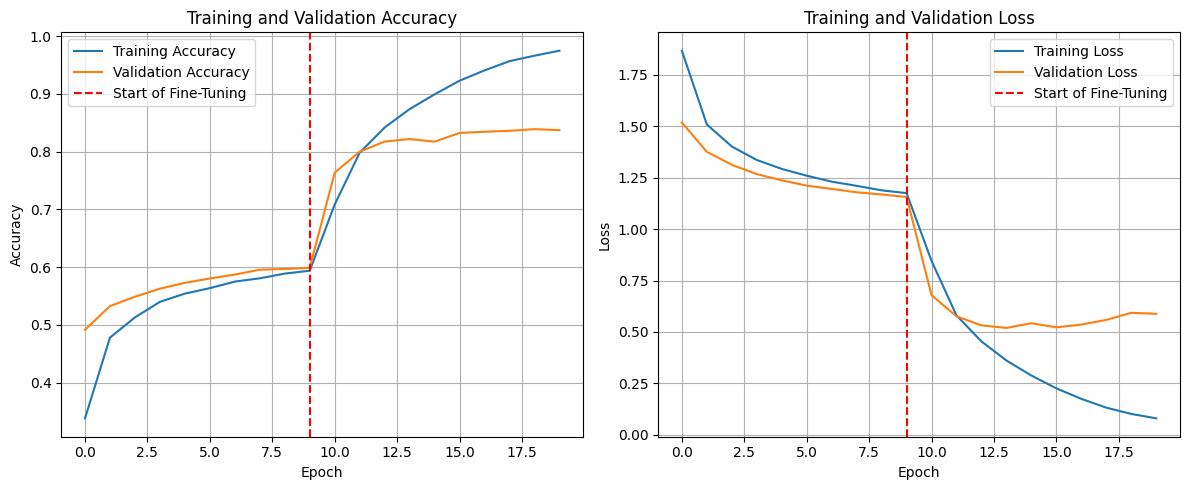


Script finished. Training history plot saved as 'training_history.png'.


In [14]:
acc = history_extraction.history['accuracy'] + history_finetune.history['accuracy']
val_acc = history_extraction.history['val_accuracy'] + history_finetune.history['val_accuracy']
loss = history_extraction.history['loss'] + history_finetune.history['loss']
val_loss = history_extraction.history['val_loss'] + history_finetune.history['val_loss']

plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.axvline(9, color='r', linestyle='--', label='Start of Fine-Tuning')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(9, color='r', linestyle='--', label='Start of Fine-Tuning')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

print("\nScript finished. Training history plot saved as 'training_history.png'.")